# Starting

QIIME2 is a powerful, extensible, and decentralized microbiome bioinformatics platform that is free, open source, and community developed. With a focus on data and analysis transparency, QIIME 2 enables researchers to start an analysis with raw DNA sequence data and finish with publication-quality figures and statistical results.
The edges and nodes in this overview do not represent specific actions or data types, but instead represent conceptual categories, e.g., the basic types of data or analytical goals we might have in an experiment.

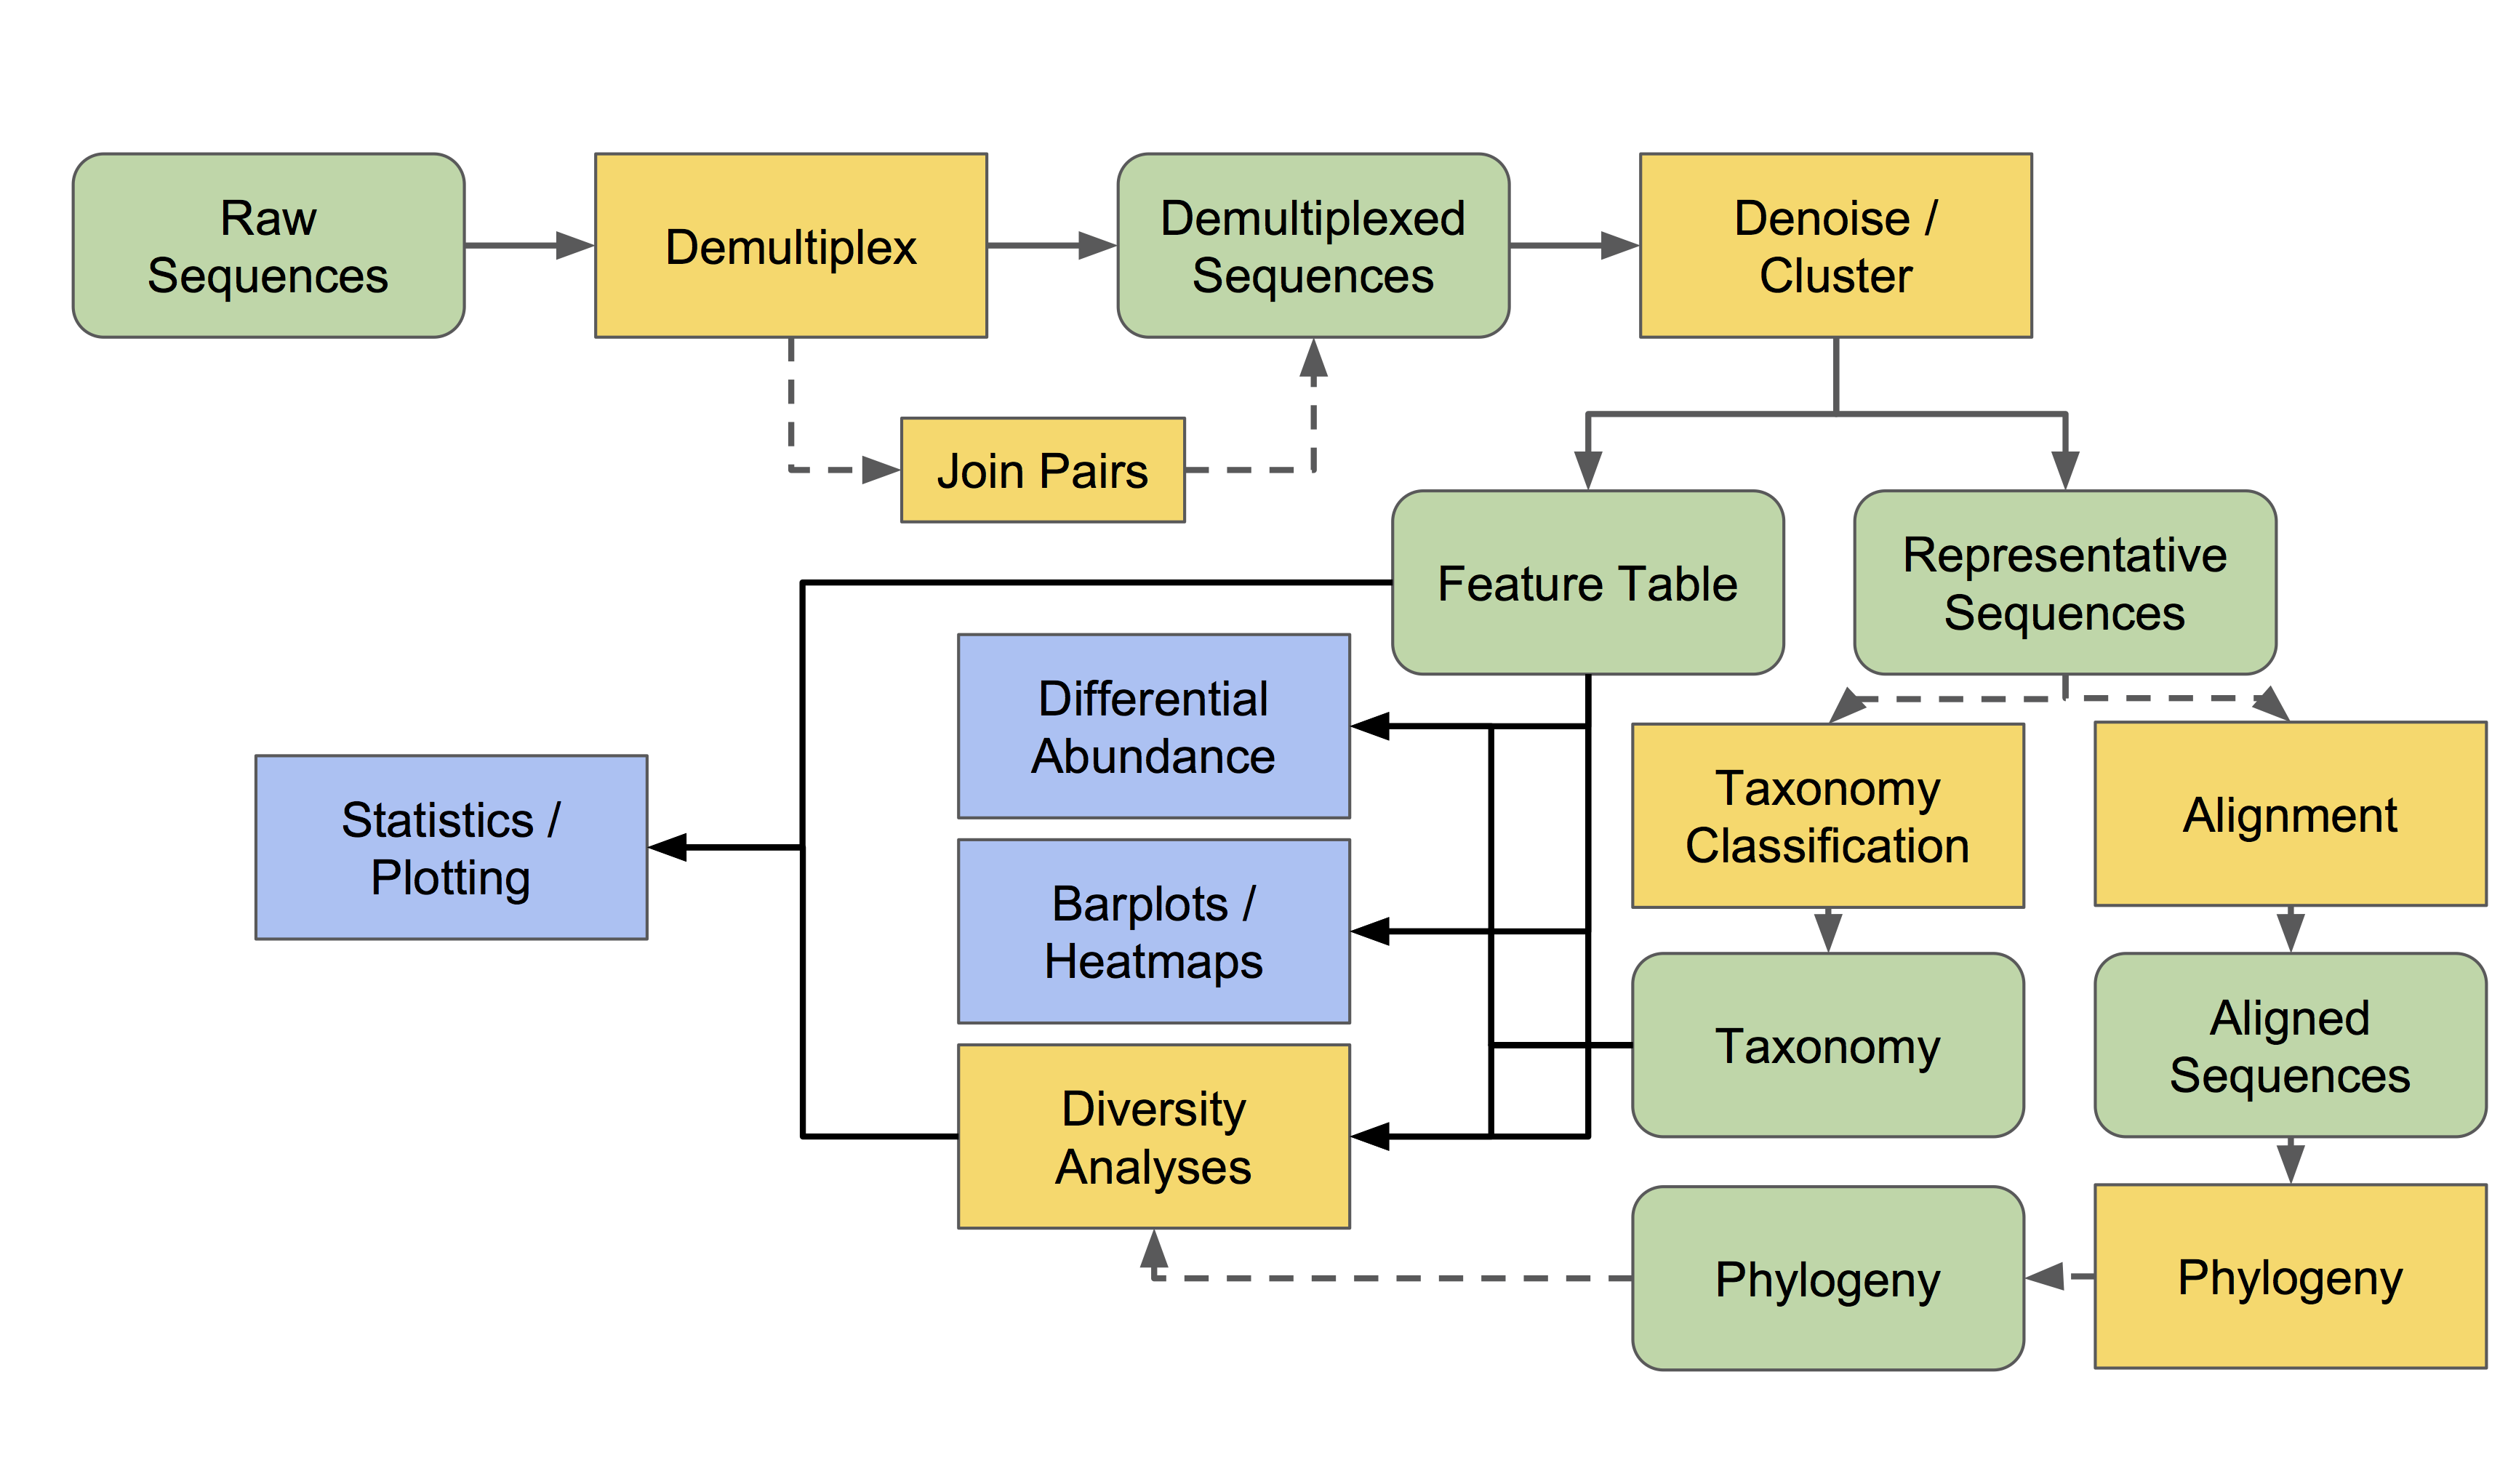

### 0. Data Cleaning and Joining of Paired-End Reads

Primer setup

In [39]:
%env PRIMER_FRW=CCTACGGGNGGCWGCAG
%env PRIMER_REV=GACTACHVGGGTATCTAATCC

env: PRIMER_FRW=CCTACGGGNGGCWGCAG
env: PRIMER_REV=GACTACHVGGGTATCTAATCC


Set working directory

In [ ]:
%env RAWDATA="/home/spuccio/datadisk2/SP021_Ponzetta16s/Dati_16S_Ponzetta/"

Create directory for trimmed reads

In [ ]:
!mkdir ../cutadapt

Create directory for joined reads

In [ ]:
!mkdir ../pear

Trimming Execution

In [ ]:
!ls *_R1_001.fastq.gz > Forward.txt
!ls *_R2_001.fastq.gz > Reverse.txt

In [ ]:
sed -e 's/_R1_001.fastq.gz//g' > a
mv a Forward.txt

In [ ]:
sed -e 's/_R2_001.fastq.gz//g' > a
mv a Reverse.txt

Trim Forward

In [ ]:
while read p; do cutadapt -g CCTACGGGNGGCWGCAG -o ../cutadapt/$p"_cutted.fastq.gz" $p".fastq.gz"; done <Forward.txt 

In [ ]:
Trim Reverse

In [ ]:
while read p; do cutadapt -g GACTACHVGGGTATCTAATCC -o ../cutadapt/$p"_cutted.fastq.gz"  $p".fastq.gz"; done <Reverse.txt

Join Paired-End with PEAR

In [ ]:
cd ../cutadapt

In [ ]:
ls * > files.txt

In [ ]:
sed -e 's/_001_cutted.fastq.gz/g' files.txt | sort -k1,1b -u - > a
mv a files.txt

In [ ]:
while read p; do pear -f $p"_R1_001_cutted.fastq.gz" -r $p"_R2_001_cutted.fastq.gz" -o ../pear/$p"_merged.fastq.gz" ; done < files.txt

Set the joined-reads directory

In [2]:
%env RAWDATA="/home/spuccio/datadisk2/SP021_Ponzetta16s/Dati_16S_Ponzetta/"

env: RAWDATA="/home/spuccio/datadisk2/SP021_Ponzetta16s/Dati_16S_Ponzetta/"


Import and validation METADATA

In [3]:
!qiime metadata tabulate \
  --m-input-file /home/spuccio/datadisk2/SP021_Ponzetta16s/metadata_nfcore.tsv \
  --o-visualization tabulated-sample-metadata.qzv

Saved Visualization to: tabulated-sample-metadata.qzv


In [5]:
%env MANIFEST=/home/spuccio/datadisk2/SP021_Ponzetta16s/manifest.csv
%env METADATA=/home/spuccio/datadisk2/SP021_Ponzetta16s/metadata_nfcore.tsv
%env CPU_CORE=10
%env CPU_THREAD=0
%env CPU_JOB=-1

env: MANIFEST=/home/spuccio/datadisk2/SP021_Ponzetta16s/manifest.csv
env: METADATA=/home/spuccio/datadisk2/SP021_Ponzetta16s/metadata_nfcore.tsv
env: OTU_MANIFEST="otu.manifest.txt"
env: CPU_CORE=10
env: CPU_THREAD=0
env: CPU_JOB=-1


### 1. Import Seq and Demultiplex

In [49]:
!qiime tools import \
--type SampleData[JoinedSequencesWithQuality] \
--input-path $MANIFEST \
--input-format SingleEndFastqManifestPhred33 \
--output-path 00.single-end-demux.qza

Imported /home/spuccio/datadisk2/SP021_Ponzetta16s/manifest.csv as SingleEndFastqManifestPhred33 to 00.paired-end-demux.qza


### 1. Visualize summary of sequencing

In [50]:
!qiime demux summarize --i-data 00.single-end-demux.qza --o-visualization vs00.single-end-demux

Saved Visualization to: vs00.single-end-demux.qzv


### 2. Quality filtering

In [52]:
!qiime quality-filter q-score-joined \
--i-demux 00.single-end-demux.qza \
--p-min-quality 20 \
--o-filtered-sequences 02.1.demux-joined-filtered.qza \
--o-filter-stats 02.2.demux-joined-filter-stats.qza

Saved SampleData[JoinedSequencesWithQuality] to: 02.1.demux-joined-filtered.qza
Saved QualityFilterStats to: 02.2.demux-joined-filter-stats.qza


### 2. Visualize summary of sequencing

In [53]:
!qiime demux summarize --i-data 02.1.demux-joined-filtered.qza --o-visualization vs02.1.single-end-demux-filtered

Saved Visualization to: vs02.1.single-end-demux-filtered.qzv


### 3. Dereplication

In [54]:
!qiime vsearch dereplicate-sequences \
--i-sequences 02.1.demux-joined-filtered.qza \
--o-dereplicated-table 03.1.table.qza \
--verbose \
--o-dereplicated-sequences 03.2.rep-seqs.qza

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --derep_fulllength /home/spuccio/datadisk2/tmp/q2-QIIME1DemuxDirFmt-c9b5wtsj/seqs.fna --output /home/spuccio/datadisk2/tmp/q2-DNAFASTAFormat-wagots78 --relabel_sha1 --relabel_keep --uc /home/spuccio/datadisk2/tmp/tmpnr7_ce2b --qmask none --xsize

vsearch v2.7.0_linux_x86_64, 118.0GB RAM, 32 cores
https://github.com/torognes/vsearch

Reading file /home/spuccio/datadisk2/tmp/q2-QIIME1DemuxDirFmt-c9b5wtsj/seqs.fna 100%                                                                                
1117172075 nt in 2684647 seqs, min 50, max 521, avg 416
Dereplicating 100%                                                                    
Sorting 100%
1911558 unique sequences, avg cluster 1.4, median 1, max 29540
Writing output file 100%                 

Removal of the singletons

In [76]:
!qiime feature-table filter-features \
 --i-table 03.1.table.qza \
 --p-min-frequency 2 \
 --o-filtered-table 03.3.merged-all-table

Saved FeatureTable[Frequency] to: 03.3.merged-all-table.qza


In [79]:
!qiime feature-table filter-seqs \
 --i-data 03.2.rep-seqs.qza \
 --i-table 03.3.merged-all-table.qza \
 --o-filtered-data 03.4.merged-all-seq

Saved FeatureData[Sequence] to: 03.4.merged-all-seq.qza


Chimera removal by de novo method

In [80]:
!qiime vsearch uchime-denovo \
--i-table 03.3.merged-all-table.qza \
--i-sequences 03.4.merged-all-seq.qza \
--output-dir ./uchime-output

Saved FeatureData[Sequence] to: ./uchime-output/chimeras.qza
Saved FeatureData[Sequence] to: ./uchime-output/nonchimeras.qza
Saved UchimeStats to: ./uchime-output/stats.qza


In [81]:
!qiime feature-table filter-features \
--i-table 03.3.merged-all-table.qza \
--m-metadata-file ./uchime-output/nonchimeras.qza \
--o-filtered-table ./uchime-output/03.5.table-nonchimeric.qza

Saved FeatureTable[Frequency] to: ./uchime-output/03.5.table-nonchimeric.qza


In [82]:
!qiime feature-table filter-seqs \
--i-data 03.4.merged-all-seq.qza \
--m-metadata-file ./uchime-output/nonchimeras.qza \
--o-filtered-data ./uchime-output/03.5.rep-seqs-nonchimeric.qza

Saved FeatureData[Sequence] to: ./uchime-output/03.5.rep-seqs-nonchimeric.qza


### 4. Sampling depth

In [83]:
!qiime feature-table summarize \
--i-table ./uchime-output/03.5.table-nonchimeric.qza \
--o-visualization 04.table.qzv

Saved Visualization to: 04.table.qzv


### 5. De novo OTU clustering

De novo OTU clustering

In [84]:
!qiime vsearch cluster-features-de-novo  \
--i-sequences ./uchime-output/03.5.rep-seqs-nonchimeric.qza \
--i-table ./uchime-output/03.5.table-nonchimeric.qza \
--p-perc-identity 0.97 \
--p-threads 25 \
--o-clustered-table 05.1.rep-table-denovo \
--o-clustered-sequences 05.2.rep-seqs-denovo

Saved FeatureTable[Frequency] to: 05.1.rep-table-denovo.qza
Saved FeatureData[Sequence] to: 05.2.rep-seqs-denovo.qza


### 6. Import Database

It has been shown that taxonomic classification accuracy of 16S rRNA gene sequences improves when a Naive Bayes classifier is trained on only the region of the target sequences that was sequenced (Werner et al., 2012). We optimize for that here by extracting reads from the reference database based on matches to this primer pair. 

In [32]:
%env IN_SEQ_DB=/home/spuccio/datadisk2/SP021_Ponzetta16s/silva_132_99_16S.fna
%env IN_TAXONOMY=/home/spuccio/datadisk2/SP021_Ponzetta16s/consensus_taxonomy_7_levels.txt

env: IN_SEQ_DB=/home/spuccio/datadisk2/SP021_Ponzetta16s/silva_132_99_16S.fna
env: IN_TAXONOMY=/home/spuccio/datadisk2/SP021_Ponzetta16s/consensus_taxonomy_7_levels.txt


In [33]:
!qiime tools import \
--input-path $IN_SEQ_DB \
--output-path 06.1.raw_99.qza \
--type 'FeatureData[Sequence]'

Imported /home/spuccio/datadisk2/SP021_Ponzetta16s/silva_132_99_16S.fna as DNASequencesDirectoryFormat to 06.1.raw_99.qza


In [34]:
!qiime tools import \
--type 'FeatureData[Taxonomy]' \
--input-format HeaderlessTSVTaxonomyFormat \
--input-path $IN_TAXONOMY \
--output-path 06.2.ref-taxonomy.qza

Imported /home/spuccio/datadisk2/SP021_Ponzetta16s/consensus_taxonomy_7_levels.txt as HeaderlessTSVTaxonomyFormat to 06.2.ref-taxonomy.qza


In [38]:
!qiime feature-classifier extract-reads \
--i-sequences 06.1.raw_99.qza \
--p-f-primer $PRIMER_FRW \
--p-r-primer $PRIMER_REV \
--o-reads 06.3.ref-seqs.qza

Saved FeatureData[Sequence] to: 06.3.ref-seqs.qza


### 7. Train Naive Bayes

In [66]:
!qiime feature-classifier fit-classifier-naive-bayes \
--i-reference-reads 06.3.ref-seqs.qza \
--i-reference-taxonomy 06.2.ref-taxonomy.qza \
--o-classifier 07.classifier.qza

Saved TaxonomicClassifier to: 07.classifier.qza


### 8. Taxonomic assignment

In [85]:
!qiime feature-classifier classify-sklearn \
--i-classifier 07.classifier.qza \
--i-reads 05.2.rep-seqs-denovo.qza \
--p-n-jobs 25 \
--o-classification 08.1.taxonomy-denovo.qza

Saved FeatureData[Taxonomy] to: 08.1.taxonomy-denovo.qza


In [86]:
!qiime taxa barplot \
--i-table 05.1.rep-table-denovo.qza \
--i-taxonomy 08.1.taxonomy-denovo.qza \
--m-metadata-file $METADATA \
--o-visualization 08.2.taxa-bar-plot-denovo.qzv

Saved Visualization to: 08.2.taxa-bar-plot-denovo.qzv


### 9. Generating the tree for phylogenetic diversity analysis

Perform de novo multiple sequence alignment using MAFFT.

In [87]:
!qiime alignment mafft \
--i-sequences 05.2.rep-seqs-denovo.qza \
--p-n-threads 10 \
--o-alignment 09.1.aligned-rep-seqs-denovo.qza

Saved FeatureData[AlignedSequence] to: 09.1.aligned-rep-seqs-denovo.qza


Mask unconserved and highly gapped columns from an alignment.

In [88]:
!qiime alignment mask \
--i-alignment 09.1.aligned-rep-seqs-denovo.qza \
--o-masked-alignment 09.2.masked-aligned-rep-seqs-denovo.qza

Saved FeatureData[AlignedSequence] to: 09.2.masked-aligned-rep-seqs-denovo.qza


Construct a phylogenetic tree with FastTree.

In [89]:
!qiime phylogeny fasttree \
--i-alignment 09.2.masked-aligned-rep-seqs-denovo.qza \
--o-tree 09.3.unrooted-tree-denovo.qza

Saved Phylogeny[Unrooted] to: 09.3.unrooted-tree-denovo.qza


Midpoint root an unrooted phylogenetic tree.

In [91]:
!qiime phylogeny midpoint-root \
--i-tree 09.3.unrooted-tree-denovo.qza \
--o-rooted-tree 09.4.rooted-tree-denovo.qza

Saved Phylogeny[Rooted] to: 09.4.rooted-tree-denovo.qza


### 10. Alpha Diversity

Observed OTUs (a qualitative measure of community richness)

In [92]:
!qiime diversity alpha \
--i-table 05.1.rep-table-denovo.qza \
--p-metric observed_otus \
--o-alpha-diversity 10.1.observed_otus_vector.qza

Saved SampleData[AlphaDiversity] to: 10.1.observed_otus_vector.qza


Chao1

In [95]:
!qiime diversity alpha \
--i-table 05.1.rep-table-denovo.qza \
--p-metric chao1 \
--o-alpha-diversity 10.2.chao1_vector.qza

Saved SampleData[AlphaDiversity] to: 10.2.chao1_vector.qza


Shannon’s diversity index (a quantitative measure of community richness)

In [96]:
!qiime diversity alpha \
--i-table 05.1.rep-table-denovo.qza \
--p-metric shannon \
--o-alpha-diversity 10.3.shannon_vector.qza

Saved SampleData[AlphaDiversity] to: 10.3.shannon_vector.qza


FaithPD

In [97]:
!qiime diversity alpha-phylogenetic \
--i-table 05.1.rep-table-denovo.qza \
--i-phylogeny 09.4.rooted-tree-denovo.qza \
--p-metric faith_pd \
--o-alpha-diversity 10.4.faith_pd_vector.qza

Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: 10.4.faith_pd_vector.qza


Calculating the main core metrics to see the metrics significance (boxplots+statistics)

In [99]:
!qiime diversity core-metrics-phylogenetic \
--i-phylogeny 09.4.rooted-tree-denovo.qza \
--i-table 05.1.rep-table-denovo.qza \
--p-sampling-depth 1000 \
--m-metadata-file $METADATA \
--output-dir 10.5.core-metrics-results-denovo

Saved FeatureTable[Frequency] to: 10.5.core-metrics-results-denovo/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: 10.5.core-metrics-results-denovo/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: 10.5.core-metrics-results-denovo/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: 10.5.core-metrics-results-denovo/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: 10.5.core-metrics-results-denovo/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: 10.5.core-metrics-results-denovo/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: 10.5.core-metrics-results-denovo/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: 10.5.core-metrics-results-denovo/jaccard_distance_matrix.qza
Saved DistanceMatrix to: 10.5.core-metrics-results-denovo/bray_curtis_distance_matrix.qza
Saved PCoAResults to: 10.5.core-metrics-results-denovo/unweighted_unifrac_pcoa_results.qza
Save

Calculating Faith PD significance

In [101]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity 10.5.core-metrics-results-denovo/faith_pd_vector.qza \
  --m-metadata-file $METADATA \
  --o-visualization ./10.5.core-metrics-results-denovo/10.6.faith-pd-group-significance.qzv 

Saved Visualization to: ./10.5.core-metrics-results-denovo/10.6.faith-pd-group-significance.qzv


Calculating Shannon's specie richness significance

In [102]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity 10.5.core-metrics-results-denovo/shannon_vector.qza \
  --m-metadata-file $METADATA \
  --o-visualization ./10.5.core-metrics-results-denovo/10.6.shannon-group-significance.qzv

Saved Visualization to: ./10.5.core-metrics-results-denovo/10.6.shannon-group-significance.qzv


Creation of the rarefaction curves

In [103]:
!qiime diversity alpha-rarefaction \
--i-table 05.1.rep-table-denovo.qza \
--i-phylogeny 09.4.rooted-tree-denovo.qza \
--p-max-depth 1000 \
--m-metadata-file $METADATA \
--o-visualization 10.6.alpha-rarefaction.qzv

Saved Visualization to: 10.6.alpha-rarefaction.qzv


Exporting the visualization plots

In [110]:
!qiime tools export --input-path 10.1.observed_otus_vector.qza --output-path ./observed_otus
!qiime tools export --input-path 10.2.chao1_vector.qza --output-path ./chao1
!qiime tools export --input-path 10.3.shannon_vector.qza --output-path ./shannon
!qiime tools export --input-path 10.4.faith_pd_vector.qza --output-path ./faith_pd
!qiime tools export --input-path ./10.5.core-metrics-results-denovo/10.6.faith-pd-group-significance.qzv --output-path ./faith_pd_significance
!qiime tools export --input-path ./10.5.core-metrics-results-denovo/10.6.shannon-group-significance.qzv --output-path ./shannon_richness_significance
!qiime tools export --input-path ./10.6.alpha-rarefaction.qzv --output-path ./alpha_rarefaction_curve

Exported 10.1.observed_otus_vector.qza as AlphaDiversityDirectoryFormat to directory ./observed_otus
Exported 10.2.chao1_vector.qza as AlphaDiversityDirectoryFormat to directory ./chao1
Exported 10.3.shannon_vector.qza as AlphaDiversityDirectoryFormat to directory ./shannon
Exported 10.4.faith_pd_vector.qza as AlphaDiversityDirectoryFormat to directory ./faith_pd
Exported ./10.5.core-metrics-results-denovo/10.6.faith-pd-group-significance.qzv as Visualization to directory ./faith_pd_significance
Exported ./10.5.core-metrics-results-denovo/10.6.shannon-group-significance.qzv as Visualization to directory ./shannon_richness_significance
Exported ./10.6.alpha-rarefaction.qzv as Visualization to directory ./alpha_rarefaction_curve


### 11. Beta diversity

Unweighted UniFrac PCoA

In [112]:
!qiime emperor plot \
--i-pcoa 10.5.core-metrics-results-denovo/unweighted_unifrac_pcoa_results.qza \
--m-metadata-file $METADATA \
--o-visualization 11.1.unweighted-unifrac-emperor.qzv 

Saved Visualization to: 11.1.unweighted-unifrac-emperor.qzv


Bray-Curtis weighted PCoA

In [114]:
!qiime emperor plot \
--i-pcoa 10.5.core-metrics-results-denovo/bray_curtis_pcoa_results.qza \
--m-metadata-file $METADATA \
--o-visualization 11.2.bray-curtis-emperor.qzv 

Saved Visualization to: 11.2.bray-curtis-emperor.qzv


Beta group significance unweighted_unifrac

In [119]:
!qiime diversity beta-group-significance \
--i-distance-matrix 10.5.core-metrics-results-denovo/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file $METADATA \
--m-metadata-column "Treatment" \
--o-visualization ./11.3unweighted-unifrac-TreatmentGroup-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.3unweighted-unifrac-TreatmentGroup-significance.qzv


In [120]:
!qiime diversity beta-group-significance \
--i-distance-matrix 10.5.core-metrics-results-denovo/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1" \
--o-visualization ./11.4.unweighted-unifrac-Treatment-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.4.unweighted-unifrac-Treatment-significance.qzv


In [121]:
!qiime diversity beta-group-significance \
--i-distance-matrix 10.5.core-metrics-results-denovo/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file $METADATA \
--m-metadata-column "Time" \
--o-visualization ./11.5.unweighted-unifrac-Time-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.5.unweighted-unifrac-Time-significance.qzv


Beta group significance bray_curtis

In [123]:
!qiime diversity beta-group-significance \
 --i-distance-matrix 10.5.core-metrics-results-denovo/bray_curtis_distance_matrix.qza \
 --m-metadata-file $METADATA \
 --m-metadata-column "Treatment" \
 --o-visualization ./11.6.bray-curtis-"Treatment"-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.6.bray-curtis-Treatment-significance.qzv


In [6]:
!qiime diversity beta-group-significance \
 --i-distance-matrix 10.5.core-metrics-results-denovo/bray_curtis_distance_matrix.qza \
 --m-metadata-file $METADATA \
 --m-metadata-column "treatment1" \
 --o-visualization ./11.7.bray-curtis-"Treatment"-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.7.bray-curtis-Treatment-significance.qzv


In [7]:
!qiime diversity beta-group-significance \
 --i-distance-matrix 10.5.core-metrics-results-denovo/bray_curtis_distance_matrix.qza \
 --m-metadata-file $METADATA \
 --m-metadata-column "Time" \
 --o-visualization ./11.8.bray-curtis-"Treatment"-significance.qzv \
--p-pairwise

Saved Visualization to: ./11.8.bray-curtis-Treatment-significance.qzv


Exporting the visualization files

In [9]:
!qiime tools export --input-path ./11.1.unweighted-unifrac-emperor.qzv --output-path ./11.1.unweighted-unifrac-pcoa
!qiime tools export --input-path ./11.2.bray-curtis-emperor.qzv --output-path ./11.2.bray-curtis-pcoa
!qiime tools export --input-path ./11.3.unweighted-unifrac-TreatmentGroup-significance.qzv --output-path ./11.3.unweighted-unifrac-TreatmentGroup-significance
!qiime tools export --input-path ./11.4.unweighted-unifrac-Treatment-significance.qzv --output-path ./11.4.unweighted-unifrac-Treatment-significance
!qiime tools export --input-path ./11.5.unweighted-unifrac-Time-significance.qzv --output-path ./11.5.unweighted-unifrac-Time-significance
!qiime tools export --input-path ./11.6.bray-curtis-Treatment-significance.qzv --output-path ./11.6.bray-curtis-Treatment-significance
!qiime tools export --input-path ./11.7.bray-curtis-Treatment-significance.qzv --output-path ./11.7.bray-curtis-Treatment-significance
!qiime tools export --input-path ./11.8.bray-curtis-Treatment-significance.qzv --output-path ./11.8.bray-curtis-Treatment-significance

Exported ./11.1.unweighted-unifrac-emperor.qzv as Visualization to directory ./11.1.unweighted-unifrac-pcoa
Exported ./11.2.bray-curtis-emperor.qzv as Visualization to directory ./11.2.bray-curtis-pcoa
Exported ./11.3.unweighted-unifrac-TreatmentGroup-significance.qzv as Visualization to directory ./11.3.unweighted-unifrac-TreatmentGroup-significance
Exported ./11.4.unweighted-unifrac-Treatment-significance.qzv as Visualization to directory ./11.4.unweighted-unifrac-Treatment-significance
Exported ./11.5.unweighted-unifrac-Time-significance.qzv as Visualization to directory ./11.5.unweighted-unifrac-Time-significance
Exported ./11.6.bray-curtis-Treatment-significance.qzv as Visualization to directory ./11.6.bray-curtis-Treatment-significance
Exported ./11.7.bray-curtis-Treatment-significance.qzv as Visualization to directory ./11.7.bray-curtis-Treatment-significance
Exported ./11.8.bray-curtis-Treatment-significance.qzv as Visualization to directory ./11.8.bray-curtis-Treatment-signifi

### 12. Abundance Cleanup

In [10]:
!qiime tools export --input-path 08.1.taxonomy-denovo.qza --output-path ./

Exported 08.1.taxonomy-denovo.qza as TSVTaxonomyDirectoryFormat to directory ./


In [12]:
!sed -i 's/Feature ID\tTaxon\tConfidence/#OTUID\ttaxonomy\tconfidence/' ./taxonomy.tsv

In [27]:
!for i in `seq 1 7`; do  qiime taxa collapse \
--i-table 05.1.rep-table-denovo.qza \
--i-taxonomy 08.1.taxonomy-denovo.qza \
--p-level $i \
--o-collapsed-table ./table-$i.qza;done

Saved FeatureTable[Frequency] to: ./table-1.qza
Saved FeatureTable[Frequency] to: ./table-2.qza
Saved FeatureTable[Frequency] to: ./table-3.qza
Saved FeatureTable[Frequency] to: ./table-4.qza
Saved FeatureTable[Frequency] to: ./table-5.qza
Saved FeatureTable[Frequency] to: ./table-6.qza
Saved FeatureTable[Frequency] to: ./table-7.qza


In [28]:
!for i in `seq 1 7`; do  qiime tools export --input-path table-$i.qza --output-path ./level-$i; done

Exported table-1.qza as BIOMV210DirFmt to directory ./level-1
Exported table-2.qza as BIOMV210DirFmt to directory ./level-2
Exported table-3.qza as BIOMV210DirFmt to directory ./level-3
Exported table-4.qza as BIOMV210DirFmt to directory ./level-4
Exported table-5.qza as BIOMV210DirFmt to directory ./level-5
Exported table-6.qza as BIOMV210DirFmt to directory ./level-6
Exported table-7.qza as BIOMV210DirFmt to directory ./level-7


In [29]:
!for i in `seq 1 7`; do  cp ./level-$i/feature-table.biom ./table-$i.biom; done

In [30]:
!for i in `seq 1 7`; do  biom add-metadata \
-i ./table-$i.biom \
-o ./table-$i-with-taxonomy.biom \
--observation-metadata-fp ./taxonomy.tsv \
--sc-separated taxonomy; done

In [31]:
!for i in `seq 1 7`; do biom convert \
-i ./table-$i-with-taxonomy.biom \
-o ./table-$i-tax.tsv --to-tsv \
--header-key taxonomy; done

In [32]:
!for i in `seq 1 7`; do sed -i '1d' ./table-$i-tax.tsv;done

In [36]:
!for i in `seq 1 7`; do sed -i '1d' table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_0__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_1__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_2__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_3__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_4__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_5__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/D_6__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/;__;__;__;__;__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/;__;__;__;__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/;__;__;__//'  table-$i-tax.tsv ; done
!for i in `seq 1 7`; do sed -i 's/;__;__//'  table-$i-tax.tsv; done 
!for i in `seq 1 7`; do sed -i 's/;__//'  table-$i-tax.tsv; done 
!for i in `seq 1 7`; do sed -i 's/#OTU ID/Taxon/' table-$i-tax.tsv ; done 

### 13. Differential abundance testing with ANCOM

ANCOM can be applied to identify features that are differentially abundant (i.e. present in different abundances) across sample groups. As with any bioinformatics method, you should be aware of the assumptions and limitations of ANCOM.

ANCOM assumes that few (less than about 25%) of the features are changing between groups.

Differential abundance Seperate WT/KO Time A

In [136]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('1WT', '2WT', '3WT', '4WT', '5KO', '6KO','7KO','8KO')" \
--o-filtered-table 13.1.SeperateWT_KO_Time_A-table.qza

Saved FeatureTable[Frequency] to: 13.1.SeperateWT_KO_Time_A-table.qza


In [137]:
!qiime composition add-pseudocount \
--i-table 13.1.SeperateWT_KO_Time_A-table.qza \
--o-composition-table 13.1.comp-SeperateWT_KO_Time_A-table.qza

Saved FeatureTable[Composition] to: 13.1.comp-SeperateWT_KO_Time_A-table.qza


In [138]:
!qiime composition ancom \
--i-table 13.1.comp-SeperateWT_KO_Time_A-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization SeperateWT_KO_Time_A-ancom.qzv

Saved Visualization to: SeperateWT_KO_Time_A-ancom.qzv


Differential abundance Seperate WT/KO Time B

In [139]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('18WT', '19WT', '20WT', '21KO', '22KO', '23KO','24KO')" \
--o-filtered-table 13.2.SeperateWT_KO_Time_B-table.qza

Saved FeatureTable[Frequency] to: 13.2.SeperateWT_KO_Time_B-table.qza


In [140]:
!qiime composition add-pseudocount \
--i-table 13.2.SeperateWT_KO_Time_B-table.qza \
--o-composition-table 13.2.comp-SeperateWT_KO_Time_B-table.qza

Saved FeatureTable[Composition] to: 13.2.comp-SeperateWT_KO_Time_B-table.qza


In [141]:
!qiime composition ancom \
--i-table 13.2.comp-SeperateWT_KO_Time_B-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization SeperateWT_KO_Time_B-ancom.qzv

Saved Visualization to: SeperateWT_KO_Time_B-ancom.qzv


Differential abundance Seperate WT Time A versus B

In [142]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('1WT', '2WT', '3WT', '4WT', '18WT', '19WT','20WT')" \
--o-filtered-table 13.3.SeperateWT_Time_A_B-table.qza

Saved FeatureTable[Frequency] to: 13.3.SeperateWT_Time_A_B-table.qza


In [143]:
!qiime composition add-pseudocount \
--i-table 13.3.SeperateWT_Time_A_B-table.qza \
--o-composition-table 13.3.comp-SeperateWT_Time_A_B-table.qza

Saved FeatureTable[Composition] to: 13.3.comp-SeperateWT_Time_A_B-table.qza


In [144]:
!qiime composition ancom \
--i-table 13.3.comp-SeperateWT_Time_A_B-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization SeperateWT_Time_A_B-ancom.qzv

Saved Visualization to: SeperateWT_Time_A_B-ancom.qzv


Differential abundance Seperate KO Time A versus B

In [145]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('5KO', '6KO', '7KO', '8KO', '21KO', '22KO','23KO','24KO')" \
--o-filtered-table 13.4.SeperateKO_Time_A_B-table.qza

Saved FeatureTable[Frequency] to: 13.4.SeperateKO_Time_A_B-table.qza


In [146]:
!qiime composition add-pseudocount \
--i-table 13.4.SeperateKO_Time_A_B-table.qza \
--o-composition-table 13.4.comp-SeperateKO_Time_A_B-table.qza

Saved FeatureTable[Composition] to: 13.4.comp-SeperateKO_Time_A_B-table.qza


In [147]:
!qiime composition ancom \
--i-table 13.4.comp-SeperateKO_Time_A_B-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization SeperateKO_Time_A_B-ancom.qzv

Saved Visualization to: SeperateKO_Time_A_B-ancom.qzv


Differential abundance Cohousing WT/KO Time A

In [148]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('10WT', '11WT', '12WT', '13KO', '14KO', '16KO')" \
--o-filtered-table 13.5.SeperateWT_KO_Time_A-table.qza

Saved FeatureTable[Frequency] to: 13.5.SeperateWT_KO_Time_A-table.qza


In [149]:
!qiime composition add-pseudocount \
--i-table 13.5.SeperateWT_KO_Time_A-table.qza \
--o-composition-table 13.5.comp-SeperateWT_KO_Time_A-table.qza

Saved FeatureTable[Composition] to: 13.5.comp-SeperateWT_KO_Time_A-table.qza


In [150]:
!qiime composition ancom \
--i-table 13.5.comp-SeperateWT_KO_Time_A-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization CohousingWT_KO_Time_A-ancom.qzv

Saved Visualization to: CohousingWT_KO_Time_A-ancom.qzv


Differential abundance Cohousing WT/KO Time B

In [97]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('25WT', '26WT', '27WT', '28WT', '29KO', '30KO','31KO','32KO')" \
--o-filtered-table 13.6.SeperateWT_KO_Time_B-table.qza

Saved FeatureTable[Frequency] to: 13.6.SeperateWT_KO_Time_B-table.qza


In [98]:
!qiime composition add-pseudocount \
--i-table 13.6.SeperateWT_KO_Time_A-table.qza \
--o-composition-table 13.6.comp-SeperateWT_KO_Time_B-table.qza

Saved FeatureTable[Composition] to: 13.6.comp-SeperateWT_KO_Time_B-table.qza


In [99]:
!qiime composition ancom \
--i-table 13.6.comp-SeperateWT_KO_Time_A-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization CohousingWT_KO_Time_B-ancom.qzv

Saved Visualization to: CohousingWT_KO_Time_B-ancom.qzv


Differential abundance Cohousing WT Time A versus B

In [100]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('10WT', '11WT', '12WT', '25WT', '26WT', '27WT','28WT')" \
--o-filtered-table 13.7.CohousingWT_Time_A_B-table.qza

Saved FeatureTable[Frequency] to: 13.7.CohousingWT_Time_A_B-table.qza


In [101]:
!qiime composition add-pseudocount \
--i-table 13.7.CohousingWT_Time_A_B-table.qza \
--o-composition-table 13.7.comp-CohousingWT_Time_A_B-table.qza

Saved FeatureTable[Composition] to: 13.7.comp-CohousingWT_Time_A_B-table.qza


In [102]:
!qiime composition ancom \
--i-table 13.7.comp-CohousingWT_Time_A_B-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization CohousingWT_Time_A_B-ancom.qzv

Saved Visualization to: CohousingWT_Time_A_B-ancom.qzv


Differential abundance Cohousing KO Time A versus B

In [106]:
!qiime feature-table filter-samples \
--i-table 05.1.rep-table-denovo.qza \
--m-metadata-file $METADATA \
--p-where "[sampleid] IN ('13KO', '14KO', '16KO', '29KO', '30KO', '31KO','32KO')" \
--o-filtered-table 13.8.CohousingKO_Time_A_B-table.qza

Saved FeatureTable[Frequency] to: 13.8.CohousingKO_Time_A_B-table.qza


In [107]:
!qiime composition add-pseudocount \
--i-table 13.8.CohousingKO_Time_A_B-table.qza \
--o-composition-table 13.8.comp-CohousingKO_Time_A_B-table.qza

Saved FeatureTable[Composition] to: 13.8.comp-CohousingKO_Time_A_B-table.qza


In [108]:
!qiime composition ancom \
--i-table 13.8.comp-CohousingKO_Time_A_B-table.qza \
--m-metadata-file $METADATA \
--m-metadata-column "treatment1_Time_Treatment" \
--o-visualization CohousingKO_Time_A_B-ancom.qzv

Saved Visualization to: CohousingKO_Time_A_B-ancom.qzv


### 14. Picrust

In [117]:
!wget ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz

--2020-05-04 22:23:54--  ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz
           => ‘gg_13_8_otus.tar.gz.1’
Resolving greengenes.microbio.me (greengenes.microbio.me)... 169.228.46.98
Connecting to greengenes.microbio.me (greengenes.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /greengenes_release/gg_13_5 ... done.
==> SIZE gg_13_8_otus.tar.gz ... 320067060
==> PASV ... done.    ==> RETR gg_13_8_otus.tar.gz ... done.
Length: 320067060 (305M) (unauthoritative)

gg_13_8_otus.tar.gz 100%[===================>] 305.24M  1.53MB/s    in 3m 42s  

2020-05-04 22:27:38 (1.38 MB/s) - ‘gg_13_8_otus.tar.gz.1’ saved [320067060]



In [ ]:
!tar -xvzf  gg_13_8_otus.tar.gz

In [119]:
!qiime tools import --type 'FeatureData[Sequence]' --input-path gg_13_8_otus/rep_set/97_otus.fasta --output-path 97_otus-GG.qza 

Imported gg_13_8_otus/rep_set/97_otus.fasta as DNASequencesDirectoryFormat to 97_otus-GG.qza


In [121]:
!qiime tools import --type 'FeatureData[Taxonomy]' --input-format HeaderlessTSVTaxonomyFormat --input-path gg_13_8_otus/taxonomy/97_otu_taxonomy.txt --output-path 97_otu-ref-taxonomy-GG.qza # import taxonomy

Imported gg_13_8_otus/taxonomy/97_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to 97_otu-ref-taxonomy-GG.qza


In [122]:
!qiime vsearch cluster-features-closed-reference \
--i-table 05.1.rep-table-denovo.qza \
--i-sequences 05.2.rep-seqs-denovo.qza \
--i-reference-sequences 97_otus-GG.qza \
--p-perc-identity 0.97 \
--o-clustered-table 14.1.tbl-cr-97.qza \
--o-clustered-sequences 14.1.rep-seqs-cr-97.qza \
--o-unmatched-sequences 14.1.unmatched-cr-97.qza

Saved FeatureTable[Frequency] to: 14.1.tbl-cr-97.qza
Saved FeatureData[Sequence] to: 14.1.rep-seqs-cr-97.qza
Saved FeatureData[Sequence] to: 14.1.unmatched-cr-97.qza


In [123]:
!qiime tools export --input-path 14.1.tbl-cr-97.qza --output-path .

Exported 14.1.tbl-cr-97.qza as BIOMV210DirFmt to directory .


In [124]:
!biom convert -i feature-table.biom -o feature-table.json.biom --to-json

In [125]:
!/home/spuccio/miniconda3/envs/qiime1/bin/normalize_by_copy_number.py -i feature-table.biom -o normalized_feature-table.biom

/home/spuccio/miniconda3/envs/qiime1/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [133]:
!/home/spuccio/miniconda3/envs/qiime1/bin/normalize_by_copy_number.py -i feature-table.biom -o otus_corrected.biom 

/home/spuccio/miniconda3/envs/qiime1/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [127]:
!/home/spuccio/miniconda3/envs/qiime1/bin/predict_metagenomes.py -f -i normalized_feature-table.biom -o kegg_metagenome_predictions.tab

/home/spuccio/miniconda3/envs/qiime1/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [128]:
!/home/spuccio/miniconda3/envs/qiime1/bin/predict_metagenomes.py -i normalized_feature-table.biom -o kegg_metagenome_predictions.biom # get a biom table to use below

/home/spuccio/miniconda3/envs/qiime1/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
!metagenome_contributions.py -i normalized_feature-table.biom -o ko_metagenome_contributions.tab

/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 6 -o kegg_metagenome_predictions_at_level6.biom
/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 5 -o kegg_metagenome_predictions_at_level5.biom
/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 4 -o kegg_metagenome_predictions_at_level4.biom
/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 3 -o kegg_metagenome_predictions_at_level3.biom
/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 2 -o kegg_metagenome_predictions_at_level2.biom
/home/spuccio/miniconda3/envs/qiime1/bin/categorize_by_function.py -i kegg_metagenome_predictions.biom -c "KEGG_Pathways" -l 1 -o kegg_metagenome_predictions_at_level1.biom

In [ ]:
biom convert -i kegg_metagenome_predictions_at_level3.biom -o pathway_predictions.txt --to-tsv --header-key KEGG_Pathways

/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level6.biom -p qiime_params_l6.txt -o plots_at_level6
/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level5.biom -p qiime_params_l5.txt -o plots_at_level5
/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level4.biom -p qiime_params_l4.txt -o plots_at_level4
/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level3.biom -p qiime_params_l3.txt -o plots_at_level3
/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level2.biom -p qiime_params_l2.txt -o plots_at_level2
/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level1.biom -p qiime_params_l1.txt -o plots_at_level1

!/home/spuccio/miniconda3/envs/qiime1/bin/summarize_taxa_through_plots.py -i kegg_metagenome_predictions_at_level5.biom -p qiime_params_l5.txt -o plots_at_level5

In [53]:
!echo $METADATA 

/home/spuccio/datadisk2/SP021_Ponzetta16s/metadata_nfcore.tsv


In [54]:
!head /home/spuccio/datadisk2/SP021_Ponzetta16s/metadata_nfcore.tsv

sampleid	treatment1	Time	Treatment	treatment1_Time_Treatment
1WT	Separate	A	WT	Separate_A_WT
2WT	Separate	A	WT	Separate_A_WT
3WT	Separate	A	WT	Separate_A_WT
4WT	Separate	A	WT	Separate_A_WT
5KO	Separate	A	KO	Separate_A_KO
6KO	Separate	A	KO	Separate_A_KO
7KO	Separate	A	KO	Separate_A_KO
8KO	Separate	A	KO	Separate_A_KO
10WT	Cohousing	A	WT	Cohousing_A_WT
